Preprocessing

In [14]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc, make_scorer, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import pickle
import os

In [16]:
# Reading files
data_client = pd.read_csv(os.path.join('..', 'data_files_and_model', 'client.csv'))
data_invoice = pd.read_csv(os.path.join('..', 'data_files_and_model', 'invoice.csv'))

Looking Through data / data cleaning

In [119]:
# Looking at header and data
print(data_client.head())

print(data_client.count())


   region        date  dis    id  catg  target
0     101  31/12/1994   60     0    11       0
1     107   29/5/2002   69     1    11       0
2     301   13/3/1986   62    10    11       0
3     105   11/7/1996   69   100    11       0
4     303  14/10/2014   62  1000    11       0
region    21652
date      21652
dis       21652
id        21652
catg      21652
target    21652
dtype: int64


In [120]:
print(data_invoice.head())

print(data_invoice.count())

   id        date  tarif_type  counter_statue  reading_remarque  \
0   0   24/3/2014          11               0                 8   
1   0   29/3/2013          11               0                 6   
2   0   23/3/2015          11               0                 8   
3   0   13/7/2015          11               0                 8   
4   0  17/11/2016          11               0                 9   

   consommation_level_4  months_number counter_type  counter_coefficient  \
0                     0              4         ELEC                    1   
1                     0              4         ELEC                    1   
2                     0              4         ELEC                    1   
3                     0              4         ELEC                    1   
4                     0             12         ELEC                    1   

   consommation_level_1  consommation_level_2  consommation_level_3  
0                    82                     0                     0  


In [121]:
# Check for missing data in client
data_client.isna().any()

region    False
date      False
dis       False
id        False
catg      False
target    False
dtype: bool

In [122]:
# Check for missing data in invoice
data_invoice.isna().any()

id                      False
date                    False
tarif_type              False
counter_statue          False
reading_remarque        False
consommation_level_4    False
months_number           False
counter_type            False
counter_coefficient     False
consommation_level_1    False
consommation_level_2    False
consommation_level_3    False
dtype: bool

There are no missing values in the dataset

In [125]:
# Drop duplicates
data_client.drop_duplicates(inplace=True)
data_invoice.drop_duplicates(inplace=True)

print(data_client.count())
print(data_invoice.count())


region    21652
date      21652
dis       21652
id        21652
catg      21652
target    21652
dtype: int64
id                      500611
date                    500611
tarif_type              500611
counter_statue          500611
reading_remarque        500611
consommation_level_4    500611
months_number           500611
counter_type            500611
counter_coefficient     500611
consommation_level_1    500611
consommation_level_2    500611
consommation_level_3    500611
dtype: int64


There are no duplicate values in the dataset as well

In [126]:
# Checking for number of unique values for each column
print(data_client.nunique())
print(data_invoice.nunique())

# Seeing what unique values there are for dis/catg columns
print(data_client.dis.unique())
print(data_client.catg.unique())

region       24
date       5984
dis           4
id        21652
catg          3
target        2
dtype: int64
id                      21652
date                     5538
tarif_type                 12
counter_statue              6
reading_remarque            4
consommation_level_4     4773
months_number             152
counter_type                2
counter_coefficient         4
consommation_level_1     3795
consommation_level_2     5348
consommation_level_3     1296
dtype: int64
[60 69 62 63]
[11 12 51]


Data Visualisation

<BarContainer object of 2 artists>

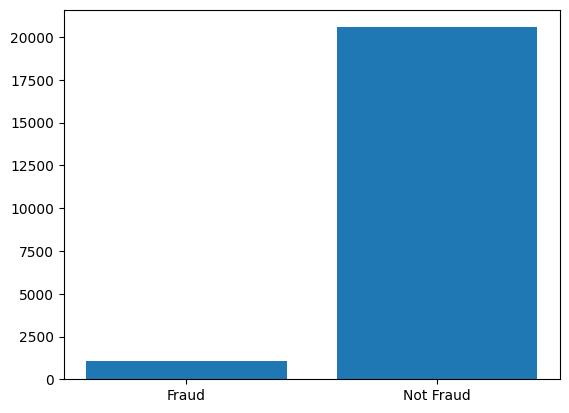

In [127]:
# Visualise dependent variable
fraud_c = data_client[data_client['target'] == 1]
not_fraud_c = data_client[data_client['target'] == 0]


plt.bar(['Fraud', 'Not Fraud'], [len(fraud_c), len(not_fraud_c)])

Significantly larger number of clients are not fraudulent compare to fraudulent clients, showcasing an imbalance dataset.

Visualising Client data to get insights

dis 
      fraud_count  not_fraud_count  client_count  percentage_of_fraud  \
dis                                                                    
60           187             5064          5251             3.561226   
62           295             6329          6624             4.453502   
63           212             4013          4225             5.017751   
69           382             5170          5552             6.880403   

     percentage_not_fraud  
dis                        
60              96.438774  
62              95.546498  
63              94.982249  
69              93.119597  


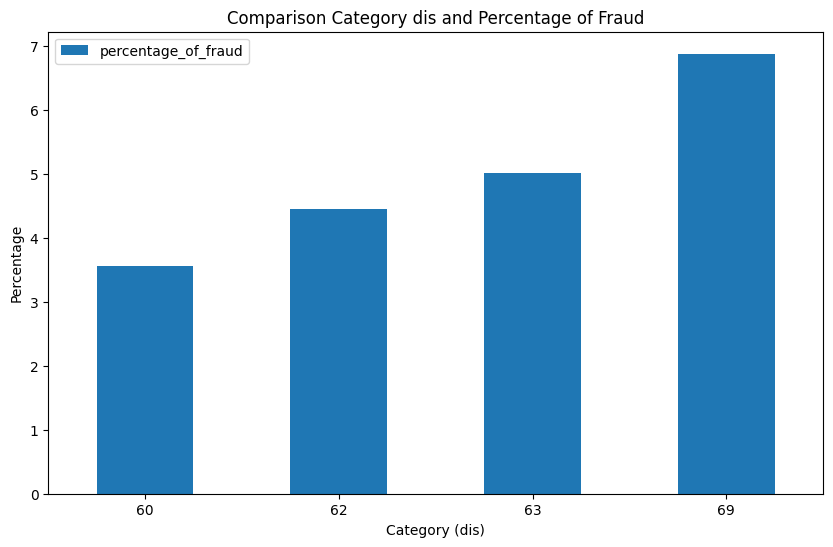

catg 
       fraud_count  not_fraud_count  client_count  percentage_of_fraud  \
catg                                                                    
11           1021            20051         21072             4.845292   
12             19              369           388             4.896907   
51             36              156           192            18.750000   

      percentage_not_fraud  
catg                        
11               95.154708  
12               95.103093  
51               81.250000  


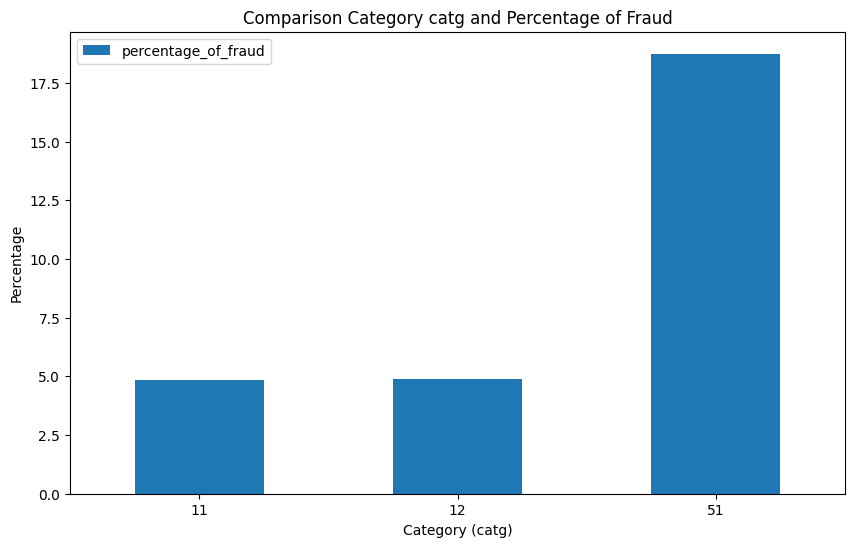

region 
         fraud_count  not_fraud_count  client_count  percentage_of_fraud  \
region                                                                    
101             195             5303          5498             3.546744   
103             132             1233          1365             9.670330   
104             113             2004          2117             5.337742   
105              10              252           262             3.816794   
106              11               97           108            10.185185   
107             115             1564          1679             6.849315   
206               1               20            21             4.761905   
301              49             1512          1561             3.139013   
302              49              683           732             6.693989   
303              29              897           926             3.131749   
304              16              525           541             2.957486   
305             

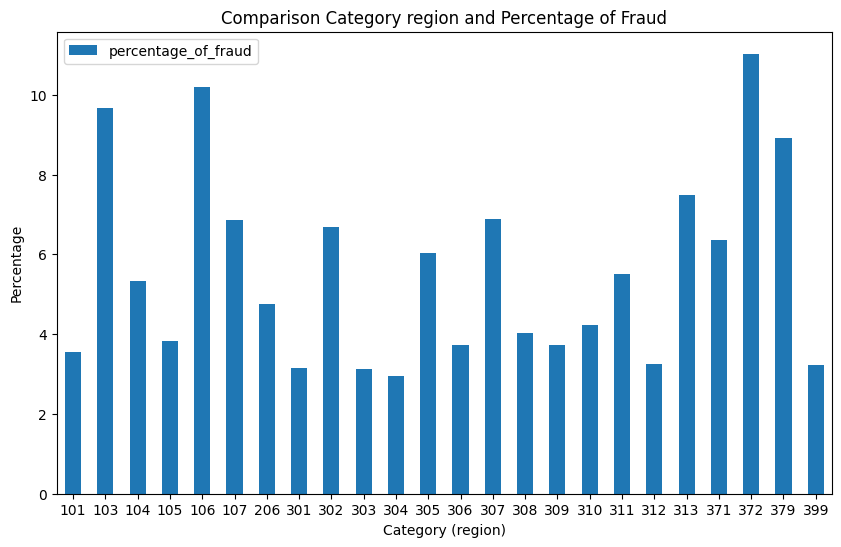

In [128]:
# Visualising categorical data in client dataset
for i in ['dis', 'catg', 'region']:
    # Getting the counts of each client category
    fraud_count = fraud_c[i].value_counts()
    client_count = data_client[i].value_counts()
    not_fraud_count = not_fraud_c[i].value_counts()

    # Calculating the percentage of fraud and non-fraud data for each variable as a percentage of client data
    percentage_of_fraud= (fraud_count / client_count) * 100
    percentage_not_fraud = (not_fraud_count / client_count) * 100

    # Fitting data into dataframe
    comparison = pd.DataFrame({
        'fraud_count': fraud_count,
        'not_fraud_count': not_fraud_count,
        'client_count': client_count,
        'percentage_of_fraud': percentage_of_fraud,
        'percentage_not_fraud': percentage_not_fraud
    })

    print(f'{i} \n', comparison)
    
    # Creating a bar plot for the percentage
    comparison[['percentage_of_fraud']].plot(kind='bar', figsize=(10, 6))

    # Setting title and labels
    plt.title(f'Comparison Category {i} and Percentage of Fraud')
    plt.xlabel(f'Category ({i})')
    plt.ylabel('Percentage')
    plt.xticks(rotation=0)

    # Displaying plot
    plt.show()

dis

- The number of client in each district is relatively equal. There is not much differences between the number of clients in each district as compared to catg to give an example. Additionally, the difference in percentage of fraud is between the district with the lowest and highest percentage of fraud only differs by about 3.3%. However, it is seen that there is a difference between every district, do we will conduct further investigation to determine if we should drop this variable.


catg

- It can be seen that even though there are a lot less catg 51 clients, there odds of a client being fraudulant are significantly higher than that of clients in other catg, at almost 5 times more likely. This can be seen in the bar plot below as well.


region

- It can be seen that the number of client in each region varies as well as that the percentage of clients being fraudulant also varies. Thus, we train this variable into our model and see how it can affect our results.

Now, to gain insights on whether each feature is statistically significant, we use Chi-Square test of independence. To explain what the Chi-Square Test of Independence is, it is a statistical test used to determine whether there's a significant association between two categorical variables. It helps answer whether the distribution of one variable is independent of the distribution of another.

In [129]:
for i in ['dis', 'catg', 'region']:
    # Evaluating the significance of categorical variables with respect to the target variable
    contingency_table = pd.crosstab(data_client[i], data_client['target'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    print(f"{i}\nChi-Square Statistic: {chi2}, p-value: {p}")

dis
Chi-Square Statistic: 68.73581935022222, p-value: 7.960199761160285e-15
catg
Chi-Square Statistic: 77.89922790072318, p-value: 1.2145001956281495e-17
region
Chi-Square Statistic: 172.14218213354502, p-value: 8.241432853155254e-25


Using the Chi-Square Test of Independence, it can be seen that all categorical variables in the client dataset is satistically significant, as all their p-values are p < 0.05. Thus, we will first leave all variables to be trained in our machine learning algorithm.

Next, we will be looking into invoice dataset, visualising the data to find any insights.

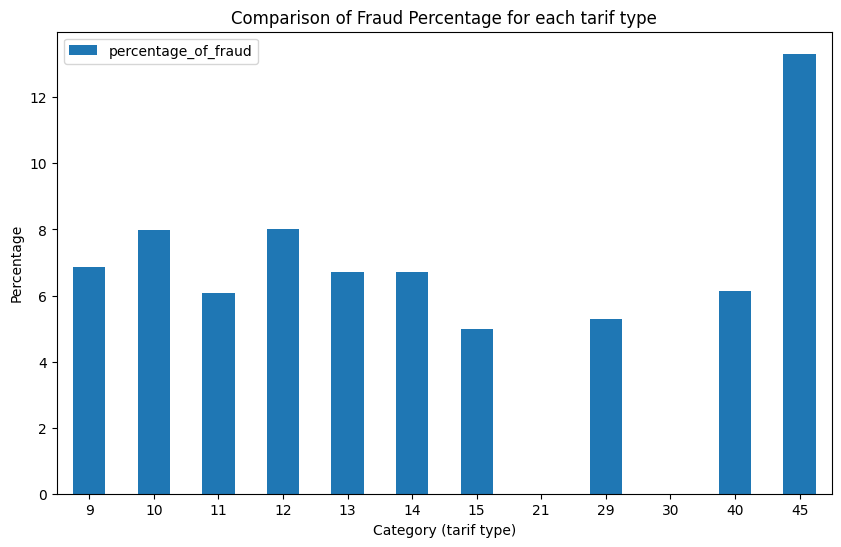

In [130]:
# Splitting invoice data into fraud and not fraud
fraud_i = data_invoice[data_invoice['id'].isin(fraud_c['id'])]
not_fraud_i = data_invoice[data_invoice['id'].isin(not_fraud_c['id'])]

# Getting the counts of each tarif type
fraud_tarif = fraud_i['tarif_type'].value_counts()
invoice_tarif = data_invoice['tarif_type'].value_counts()

# Calculating the percentage of fraud data for each tarif type as a percentage of client data
percentage_of_fraud = (fraud_tarif / invoice_tarif) * 100

# Fitting data into dataframe
comparison = pd.DataFrame({
    'fraud_tarif': fraud_tarif,
    'invoice_tarif': invoice_tarif,
    'percentage_of_fraud': percentage_of_fraud
})

# Creating a bar plot for the percentage
comparison[['percentage_of_fraud']].plot(kind='bar', figsize=(10, 6))

# Setting title and labels
plt.title('Comparison of Fraud Percentage for each tarif type')
plt.xlabel('Category (tarif type)')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Displaying plot
plt.show()

It can be seen that the tarif type does not really affect the probability of an invoice being from a fraudulant client, as the bar graph above is actually quite horizontal throughout, with the exception of tarif type 45 that is almost twice as likely. However this may not be significant in the whole scheme of things, so we will further investigate the other features.

In [131]:
# Displaying data based on tarif type for both fraud and non-fraud data that I seperated above
print(fraud_tarif)
print(invoice_tarif)

tarif_type
11    21821
40     5420
10     3781
15      120
45       63
12       34
9        32
29       31
14       30
13       30
Name: count, dtype: int64
tarif_type
11    359560
40     88482
10     47285
15      2405
29       587
45       473
9        466
13       446
14       446
12       425
30        19
21        17
Name: count, dtype: int64


Viewing the number of each value of tarif to see if there are big differences between tarif types. It can be seen that tarif type 11 is much higher than the other values. Also, while the percentage of fraudulant invoices with tarif type 45 is higher, it actually does not account to many invoices. 

Now, we once again want to view the statistical significance of the categorical variables in invoice data, using Chi-Square test of independence.

In [132]:
merged_df = pd.merge(data_invoice, data_client, on='id', how='inner')
for i in ['tarif_type', 'counter_statue', 'counter_type']:
    # Evaluating the significance of categorical variables with respect to the target variable
    contingency_table = pd.crosstab(merged_df[i], merged_df['target'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 320.7354307026131, p-value: 3.712248147090872e-62
Chi-Square Statistic: 23.783567918825717, p-value: 0.00023892055698261985
Chi-Square Statistic: 1.9061354716353593, p-value: 0.1673931693261903


Using Chi-Square test of independence, it can be seen that the p-value of column 'counter type' > 0.05 thus it is not statistically significant, and we will drop the column from our analysis. 

Now, we want to look into the numerical values of consommation levels to see what insights we can obtain.

In [133]:
# List of consumption level columns
consumption_cols = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'reading_remarque']

# Calculate min, max, and average for the consumption columns
min_values_f = fraud_i[consumption_cols].min()
max_values_f = fraud_i[consumption_cols].max()
mean_values_f = fraud_i[consumption_cols].mean()

min_values_n = not_fraud_i[consumption_cols].min()
max_values_n = not_fraud_i[consumption_cols].max()
mean_values_n = not_fraud_i[consumption_cols].mean()

# Display the results
print("Minimum values: \nFraud" )
print(min_values_f)
print("Not Fraud")
print(min_values_n)

print("\nMaximum values: \nFraud")
print(max_values_f)
print("Not Fraud")
print(max_values_n)

print("\nAverage values: \nFraud")
print(mean_values_f)
print("Not Fraud")
print(mean_values_n)

Minimum values: 
Fraud
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
reading_remarque        6
dtype: int64
Not Fraud
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
reading_remarque        6
dtype: int64

Maximum values: 
Fraud
consommation_level_1     30080
consommation_level_2     25997
consommation_level_3      5345
consommation_level_4    116145
reading_remarque             9
dtype: int64
Not Fraud
consommation_level_1     98889
consommation_level_2    819886
consommation_level_3     45360
consommation_level_4    343568
reading_remarque             9
dtype: int64

Average values: 
Fraud
consommation_level_1    499.839774
consommation_level_2    160.204547
consommation_level_3     53.134335
consommation_level_4    127.809387
reading_remarque          7.555864
dtype: float64
Not Fraud
consommation_level_1    439.308751
consommation_level_2    117.865928
consommation_leve

While the min consommation for all categories looked at above is 0, these values are gotten based on the whole data set and what are the overall values of min, mean and max value of each feature, so while we can visualise the data below, we will not be looking at the min values, we will still be looking at min values later. We will now visualise the data below to gain more insights. 

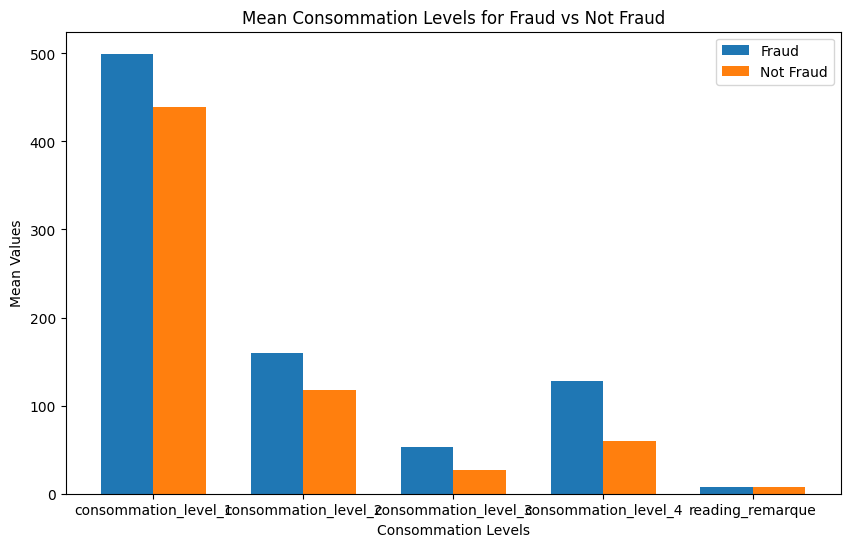

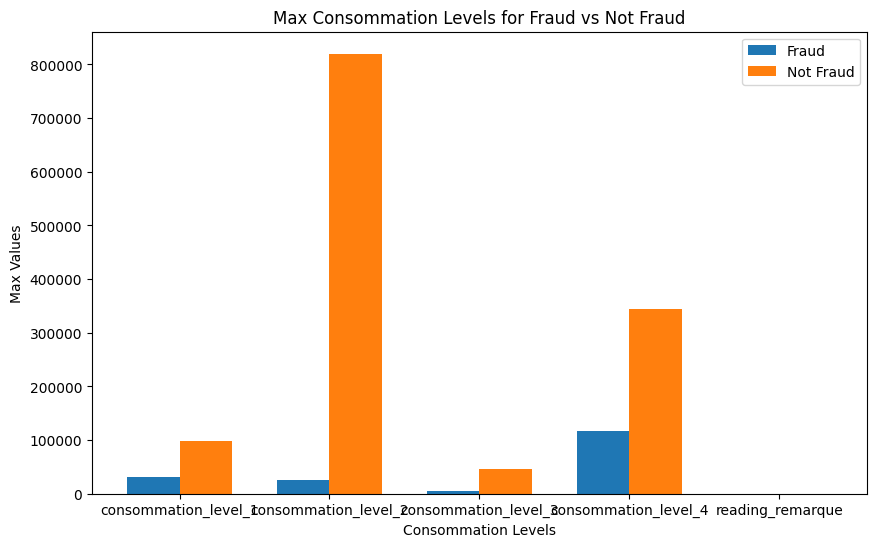

In [134]:
def plot_consommation_graphs(fraud_data, not_fraud_data, title):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Get a range for the x-axis labels
    index = np.arange(len(consumption_cols))

    # Define the bar width
    bar_width = 0.35

    # Plot the fraud and not fraud means side by side
    bar1 = ax.bar(index, fraud_data, bar_width, label='Fraud')
    bar2 = ax.bar(index + bar_width, not_fraud_data, bar_width, label='Not Fraud')

    # Adding labels, title, and x-axis ticks
    ax.set_xlabel('Consommation Levels')
    ax.set_ylabel(f'{title} Values')
    ax.set_title(f'{title} Consommation Levels for Fraud vs Not Fraud')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(consumption_cols)
    ax.legend()

    # Displaying plot
    plt.show()

# Viewing graphs for mean and max consommation level
plot_consommation_graphs(mean_values_f, mean_values_n, 'Mean')
plot_consommation_graphs(max_values_f, max_values_n, 'Max')

It can be seen that the mean consommation level for fraud invoices are always higher than that of non-fraudulant invoices, yet the max consommation level for fraud is much less than that of not fraud at all consommation levels. 

Feature Engineering

With not much information on the features and what they mean, it was difficult to feature engineer, making better use of the features given. This may lead to some of the simpler models we use later to not be able to produce great results in detecting fraud. However, we did what we could with the information given and tried some methods to make our data more useful.

Firstly by changing the date column to a datetime data type to be used for more useful information such as tenure and days since last invoice.

In [17]:
# Convert date column to datetime
data_client['date'] = pd.to_datetime(data_client['date'])

# Extract year, month, and tenure
data_client['year_joined'] = data_client['date'].dt.year
data_client['month_joined'] = data_client['date'].dt.month
data_client['tenure'] = (pd.to_datetime('today') - data_client['date']).dt.days

# Convert to datetime and extract features
data_invoice['date'] = pd.to_datetime(data_invoice['date'])
data_invoice['year'] = data_invoice['date'].dt.year
data_invoice['month'] = data_invoice['date'].dt.month
data_invoice['days_since_last_invoice'] = (pd.to_datetime('today') - data_invoice['date']).dt.days

print(data_client.head())
print(data_invoice.head())

/var/folders/t2/_hypj1cj7gj6b3j_nd6zhsgr0000gn/T/ipykernel_67064/1726339021.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_client['date'] = pd.to_datetime(data_client['date'])
/var/folders/t2/_hypj1cj7gj6b3j_nd6zhsgr0000gn/T/ipykernel_67064/1726339021.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_invoice['date'] = pd.to_datetime(data_invoice['date'])


   region       date  dis    id  catg  target  year_joined  month_joined  \
0     101 1994-12-31   60     0    11       0         1994            12   
1     107 2002-05-29   69     1    11       0         2002             5   
2     301 1986-03-13   62    10    11       0         1986             3   
3     105 1996-07-11   69   100    11       0         1996             7   
4     303 2014-10-14   62  1000    11       0         2014            10   

   tenure  
0   10900  
1    8194  
2   14115  
3   10342  
4    3673  
   id       date  tarif_type  counter_statue  reading_remarque  \
0   0 2014-03-24          11               0                 8   
1   0 2013-03-29          11               0                 6   
2   0 2015-03-23          11               0                 8   
3   0 2015-07-13          11               0                 8   
4   0 2016-11-17          11               0                 9   

   consommation_level_4  months_number counter_type  counter_coefficient  

For feature selection, we will be using backward selection that we have done in the backward.ipynb file to choose the features we will be using for our development of the our model below.

In [18]:
data_invoice = data_invoice.drop(columns=['date', 'year', 'month', 'months_number', 'counter_type', 'tarif_type', 'counter_coefficient', 'consommation_level_2'])
data_client = data_client.drop(columns=['date', 'year_joined', 'month_joined'])

Based on above analysis and backward selection of features, we have dropped the above columns to improve classificaton of model.

We now want to aggregate the consommation levels and reading remarque of each client to view the mean, min, max data to be used in our model. Following that, we standardised the numerical data, so that it can be used for KNN where distance metrics are used, while it also assist my logistic regression model in reaching faster convergence.

In [19]:

agg_invoice = data_invoice.groupby('id').agg({
    'consommation_level_1': ['mean', 'min', 'max'],
    'consommation_level_3': ['mean', 'min', 'max'],
    'consommation_level_4': ['mean', 'min', 'max'],
    'reading_remarque': ['min','max'],
})
# Flatten the MultiIndex columns in agg_merged
agg_invoice.columns = ['_'.join(col).strip() for col in agg_invoice.columns.values]
agg_invoice.reset_index(inplace=True)

# Merge data_merged with the aggregated statistics
data_invoice = pd.merge(data_invoice, agg_invoice, on='id', how='inner')

numeric = ['consommation_level_1', 'consommation_level_3', 'consommation_level_4', 'consommation_level_1_min', 'consommation_level_1_max', 'consommation_level_1_mean', 'consommation_level_3_min', 'consommation_level_3_max', 'consommation_level_3_mean', 'consommation_level_4_min', 'consommation_level_4_max', 'consommation_level_4_mean', 'reading_remarque', 'reading_remarque_max', 'reading_remarque_min', 'days_since_last_invoice']
data_invoice[numeric] = StandardScaler().fit_transform(data_invoice[numeric])

data_merged = pd.merge(data_invoice, data_client, on='id', how='inner')
# Display the first few rows to confirm the merge worked
print(data_merged.head())

   id  counter_statue  reading_remarque  consommation_level_4  \
0   0               0          0.390197             -0.052332   
1   0               0         -1.064976             -0.052332   
2   0               0          0.390197             -0.052332   
3   0               0          0.390197             -0.052332   
4   0               0          1.117783             -0.052332   

   consommation_level_1  consommation_level_3  days_since_last_invoice  \
0             -0.609651             -0.131748                -0.175151   
1              1.278068             -0.131748                 0.055799   
2             -0.540424             -0.131748                -0.408667   
3             -0.575882             -0.131748                -0.480518   
4              0.217703             -0.131748                -0.796791   

   consommation_level_1_mean  consommation_level_1_min  \
0                  -0.271221                 -0.173744   
1                  -0.271221                 -0.

We then used One-hot encoding for categorical data to convert categories into a numerical format that machine learning models can understand. It prevents the model from assuming any ordinal relationship between categories by representing each category as a separate binary feature, ensuring fair and unbiased learning from the data.

In [20]:
data_merged_encoded = pd.get_dummies(data_merged, columns=['dis', 'catg', 'region', 'counter_statue'], drop_first=True)
data_merged_encoded = data_merged_encoded.astype(int)
print(data_merged_encoded)

            id  reading_remarque  consommation_level_4  consommation_level_1  \
0            0                 0                     0                     0   
1            0                -1                     0                     1   
2            0                 0                     0                     0   
3            0                 0                     0                     0   
4            0                 1                     0                     0   
...        ...               ...                   ...                   ...   
500646  128438                -1                     0                     0   
500647  128438                -1                     0                     0   
500648  128438                -1                     0                     0   
500649  128438                 1                     0                     0   
500650  128438                -1                     0                     0   

        consommation_level_3  days_sinc

Dropping of duplicates after completing our feature engineering with our data.

In [21]:
# Check the initial number of rows
initial_shape = data_merged_encoded.shape[0]

# Drop duplicates
data_merged_encoded.drop_duplicates(inplace=True)

# Check the new number of rows
new_shape = data_merged_encoded.shape[0]

# Calculate the number of duplicates dropped
duplicates_dropped = initial_shape - new_shape

print(f"Number of duplicates dropped: {duplicates_dropped}")

Number of duplicates dropped: 372242


Now we need to seperated data into xtrain, ytrain to be used for model training and xtest, ytest to be used for model testing. This allows us to evaluate model performance on unseen data, ensuring it generalizes well to new information and doesn't just memorize the training data.

In [22]:
xval = data_merged_encoded.drop(columns=['target', 'id'])
yval = data_merged_encoded['target']

# Split the data train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(xval, yval, test_size=0.3, random_state=0)

print('xtrain shape:', xtrain.shape)
print('xtest shape:', xtest.shape)
print('ytrain shape:', ytrain.shape)
print('ytest shape:', ytest.shape)

xtrain shape: (89886, 50)
xtest shape: (38523, 50)
ytrain shape: (89886,)
ytest shape: (38523,)


Due to dataset being highly imbalanced due to the significantly lower number of fraud clients compared to non fraud clients, we used oversampling to prevent the model from being biased toward the majority class. This helps improve the model's ability to correctly predict the minority class, resulting in more accurate and fairer performance on imbalanced data.

In [23]:
# Create the SMOTE object
smote = SMOTE(random_state=42)

# Fit and apply the oversampling
xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

# Check the class distribution
print(f"Original training set shape: {np.bincount(ytrain)}")
print(f"Resampled training set shape: {np.bincount(ytrain_resampled)}")

Original training set shape: [83667  6219]
Resampled training set shape: [83667 83667]


Modeling

The first algorithm we are going to use is logistic regression. It is a simple model that predicts the probability of a binary outcome (0 or 1) based on one or more predictor variables. While it may struggle with to accurately predict the outcomes we expect in fraud detection cases due to the imbalanced dataset, non-linear pattern and in this case, a sparse and high-dimensional data set, we can use techiniques like SMOTE to solve a challenge faced by logistic regression and also, it gives us a base line to compare with for our other models. 

In [161]:
# Initialize the logistic regression model
logit_reg = LogisticRegression(random_state=0, max_iter=1000)

# Fit the model to the training data
logit_reg.fit(xtrain_resampled, ytrain_resampled)

y_pred_lr = logit_reg.predict(xtest)

# Print evaluation metrics
print("Accuracy:", accuracy_score(ytest, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_lr))
print("Classification Report:\n", classification_report(ytest, y_pred_lr))

Accuracy: 0.6208758404070296
Confusion Matrix:
 [[22272 13521]
 [ 1084  1646]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75     35793
           1       0.11      0.60      0.18      2730

    accuracy                           0.62     38523
   macro avg       0.53      0.61      0.47     38523
weighted avg       0.89      0.62      0.71     38523



/Users/angxavier/Documents/GitHub/IT1244-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Looking at the results from running the logistic regression model on our test data, it can be seen that while it gives a reasonable overall accuracy, it performs poorly in identifying fraud cases (class 1). While it has a reasonable recall rate, the low precision, and F1-score for class 1 suggest that the model is not effective for the fraud detection task. After identifying fraud cases, the precision shows that it may require further investigation to properly determine the true positives. 

In [162]:
# Adjusting threshold
y_pred_probs = logit_reg.predict_proba(xtest)[:, 1]
custom_threshold = 0.3
y_pred_custom = (y_pred_probs >= custom_threshold).astype(int)
print(confusion_matrix(ytest, y_pred_custom))
print(classification_report(ytest, y_pred_custom))


[[ 8225 27568]
 [  342  2388]]
              precision    recall  f1-score   support

           0       0.96      0.23      0.37     35793
           1       0.08      0.87      0.15      2730

    accuracy                           0.28     38523
   macro avg       0.52      0.55      0.26     38523
weighted avg       0.90      0.28      0.35     38523



While changing the threshold helped achieve a high recall for fraud cases (indicating better detection of fraud), the overall accuracy and recall for non-fraud cases dropped significantly, leading to many false positives. Thus, the overall model performance has worsened due to the low accuracy and poor recall for non-fraud cases, despite some improvement in identifying fraud cases. The model is now more biased toward predicting fraud, but this has led to many incorrect classifications of non-fraud cases.

Next, we will leave the above to the side for now. We will then look at using K-Nearest Neighbors(KNN) for classification. KNN is a simple, non-parametric machine learning algorithm used for classification. It operates on the principle that similar data points are located close to each other in feature space. We are using KNN as it is a straightforward algorithm that is easy to understand and implement. While we understand that there many considerations to running a KNN algorithm as well, due to scalability issues, curse of dimensionality and imbalance dataset, we have done our best to ensure that we simplified the data significantly, did some feature engineering and feature selection to reduce the dimension of the data. Furthermore, we will run KNN with multiple K values to test and select the best K value.

In [183]:
for i in range(1,11):    
    # Initialize the KNN classifier
    k = i
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model
    knn.fit(xtrain_resampled, ytrain_resampled)

    # Make predictions on the test set
    y_pred_knn = knn.predict(xtest)

    print(f'k = {i}')
    print("Accuracy:", accuracy_score(ytest, y_pred_knn))
    print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_knn))
    print("Classification Report:\n", classification_report(ytest, y_pred_knn))

k = 1
Accuracy: 0.9679412299145965
Confusion Matrix:
 [[35077   716]
 [  519  2211]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     35793
           1       0.76      0.81      0.78      2730

    accuracy                           0.97     38523
   macro avg       0.87      0.89      0.88     38523
weighted avg       0.97      0.97      0.97     38523

k = 2
Accuracy: 0.9713417958102951
Confusion Matrix:
 [[35394   399]
 [  705  2025]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     35793
           1       0.84      0.74      0.79      2730

    accuracy                           0.97     38523
   macro avg       0.91      0.87      0.89     38523
weighted avg       0.97      0.97      0.97     38523

k = 3
Accuracy: 0.9636580743971134
Confusion Matrix:
 [[34803   990]
 [  410  2320]]
Classification Report:
               preci

With the dataset still being large, running multiple K values takes a lot of time and computational power, thus we will only used a range from 1 to 10. From this, we will further investigate using the best K value using only the top 5 K values from above with the highest f1-score fraud cases (class 1) which takes into account both the precision and recall of those fraud cases. It can be seen that k values [1, 2, 3, 4, 6] has the highest f1-score, thus we will then put it into a cross validation selection to select the best K value.

In [184]:
shortlisted_k_values = [1, 2, 3, 4, 6]
recall_scores = []
f1_scores = []

for k in shortlisted_k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use cross-validation for recall and F1-score on shortlisted values
    recall = cross_val_score(knn, xtrain_resampled, ytrain_resampled, cv=5, scoring=make_scorer(recall_score, pos_label=1))
    f1 = cross_val_score(knn, xtrain_resampled, ytrain_resampled, cv=5, scoring=make_scorer(f1_score, pos_label=1))
    recall_scores.append(np.mean(recall))
    f1_scores.append(np.mean(f1))

# Display cross-validated scores
for i, k in enumerate(shortlisted_k_values):
    print(f'k = {k}: Recall = {recall_scores[i]:.4f}, F1-Score = {f1_scores[i]:.4f}')

# Choose the best k based on the cross-validated metrics
best_k_index = np.argmax(f1_scores) 
best_k = shortlisted_k_values[best_k_index]
print(f"Optimal k based on cross-validated F1-Score: {best_k}")

k = 1: Recall = 0.9100, F1-Score = 0.9404
k = 2: Recall = 0.8769, F1-Score = 0.9270
k = 3: Recall = 0.9571, F1-Score = 0.9598
k = 4: Recall = 0.9819, F1-Score = 0.9653
k = 6: Recall = 0.9831, F1-Score = 0.9557
Optimal k based on cross-validated F1-Score: 4


Thus, we use k = 4 to retrain the model.

In [24]:
# Initialize the KNN model with the optimal k value
optimal_k = 4  
opt_knn = KNeighborsClassifier(n_neighbors=optimal_k)

# Retrain the model on the entire training dataset
opt_knn.fit(xtrain_resampled, ytrain_resampled)

# Make predictions on the test set
y_pred_opt_knn = opt_knn.predict(xtest)

# Print classification report
print(classification_report(ytest, y_pred_opt_knn, target_names=['Non-Fraud', 'Fraud']))

# Calculate and print AUC-ROC
y_pred_proba = opt_knn.predict_proba(xtest)[:, 1]  # Probability for the 'Fraud' class
roc_auc = roc_auc_score(ytest, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

              precision    recall  f1-score   support

   Non-Fraud       0.99      0.96      0.97     35793
       Fraud       0.62      0.91      0.74      2730

    accuracy                           0.95     38523
   macro avg       0.81      0.93      0.85     38523
weighted avg       0.97      0.95      0.96     38523

AUC-ROC: 0.9724


We can see that while the results we got from our KNN model is quite satisfactory, it has a high time complexity and take 10 min to run through the k values from 1 to 10 and another 30mins for cross validation. Thus, finding the optimal k value and building the model actually took a long time, the model itself using k = 4 actually only ran for 2min30s. So it can still be an effective way to classify fraud data, given its high f1-score.

Lastly, we used random forest classifier.

In [219]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
rf.fit(xtrain_resampled, ytrain_resampled)

# Make predictions
y_pred_rf = rf.predict(xtest)

print("Accuracy:", accuracy_score(ytest, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_rf))
print("Classification Report:\n", classification_report(ytest, y_pred_rf))

Accuracy: 0.8994886171897308
Confusion Matrix:
 [[33478  2315]
 [ 1557  1173]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     35793
           1       0.34      0.43      0.38      2730

    accuracy                           0.90     38523
   macro avg       0.65      0.68      0.66     38523
weighted avg       0.91      0.90      0.91     38523



While the accuracy of the Random Forest Classifier is very high at about 0.89949, the precision, recall and f1-score of fraud cases (class 1) are all quite low, below 0.50 for all metrics. Thus, it may not be the best model for fraud detection, where we put more emphasis on identifying the minority class, frauds. We thus then move on to tune the parameters used for Random Forest Classifier to attempt to improve the model. 

In [206]:
# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', {0: 1, 1: 3}]
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_distributions=param_dist,
    scoring='f1_weighted',  
    cv=5,
    n_iter=50,  
    n_jobs=-1
)

random_search.fit(xtrain_resampled, ytrain_resampled)

# Getting the best parameters
best_params = random_search.best_params_

In [210]:
# Extract the best hyperparameters and re-instantiate the RandomForestClassifier
best_rf_model = RandomForestClassifier(**best_params, random_state=0)

# Fit this model on your training data
best_rf_model.fit(xtrain_resampled, ytrain_resampled)

# Predict on the test data
y_pred_best_rf = best_rf_model.predict(xtest)

# Evaluate the model performance on test data and display the results
print("Accuracy:", accuracy_score(ytest, y_pred_best_rf))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_best_rf))
print("Classification Report:\n", classification_report(ytest, y_pred_best_rf))

Accuracy: 0.8994367001531552
Confusion Matrix:
 [[33455  2338]
 [ 1536  1194]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95     35793
           1       0.34      0.44      0.38      2730

    accuracy                           0.90     38523
   macro avg       0.65      0.69      0.66     38523
weighted avg       0.91      0.90      0.91     38523



Even after running Randomised Search and finding the best parameters, the model actually did not change in terms of the results. Thus, we move on to try adjusting threshold levels. 

In [232]:
# Get the prediction probabilities
y_pred_proba = best_rf_model.predict_proba(xtest)

# Set a custom threshold (e.g., 0.3) for classifying as positive class
threshold = 0.4
y_pred_adjusted_rf = (y_pred_proba[:, 1] >= threshold).astype(int)

# Evaluate the adjusted predictions
print("Accuracy:", accuracy_score(ytest, y_pred_adjusted_rf))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_adjusted_rf))
print("Classification Report:\n", classification_report(ytest, y_pred_adjusted_rf))

Accuracy: 0.8915453105936713
Confusion Matrix:
 [[33023  2770]
 [ 1408  1322]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     35793
           1       0.32      0.48      0.39      2730

    accuracy                           0.89     38523
   macro avg       0.64      0.70      0.66     38523
weighted avg       0.91      0.89      0.90     38523



After testing with multiple threshold levels, at a threshold of 0.4, gives the best results, which gie a precision of 0.32, recall rate of 0.48 and f1 score of 0.39 for fraud cases (class 1). This is still poor if we were to use this algorithm for fraud detection.

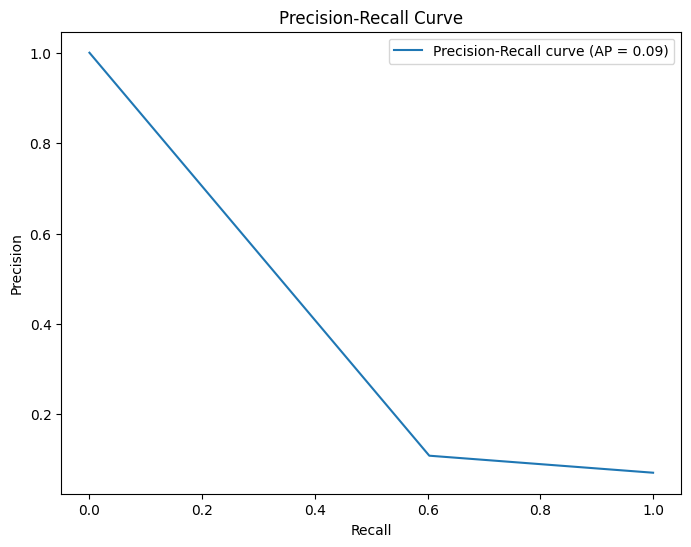

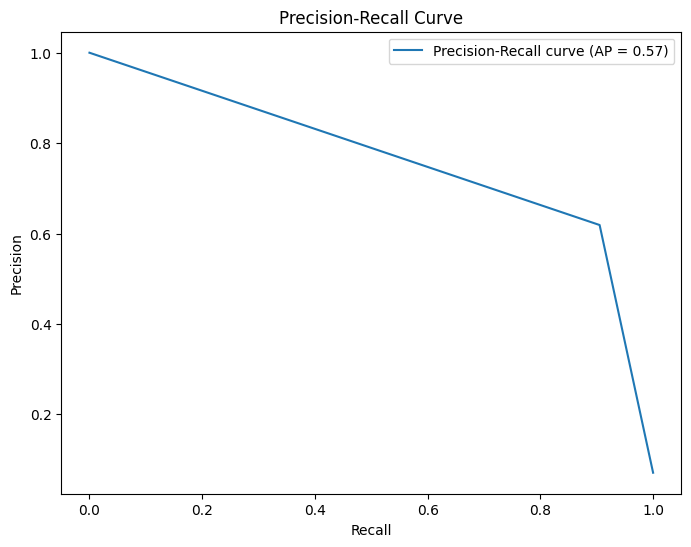

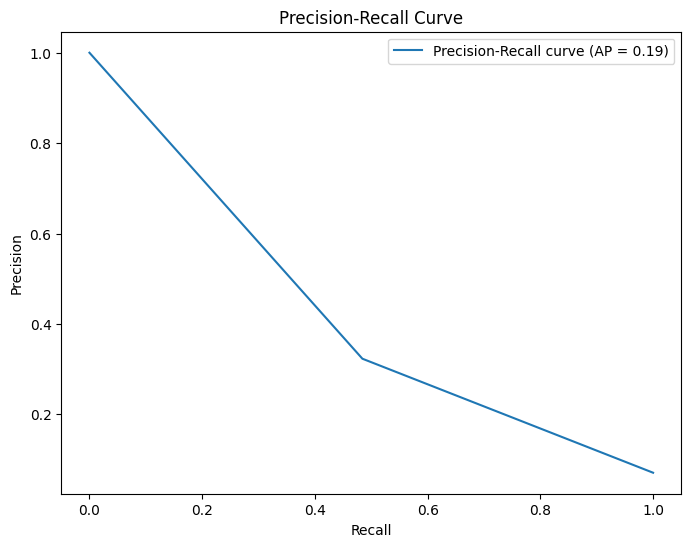

In [251]:
for i in [y_pred_lr, y_pred_opt_knn, y_pred_adjusted_rf]:
    # Calculate precision, recall
    precision, recall, thresholds = precision_recall_curve(ytest, i)
    average_precision = average_precision_score(ytest, i)

    # Plotting the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

In [228]:
dic = {'lr':y_pred_lr, 'knn':y_pred_opt_knn, 'rf':y_pred_best_rf}
for i in dic:
    precision = precision_score(ytest, dic[i])
    recall = recall_score(ytest, dic[i])
    f1 = f1_score(ytest, dic[i])

    print(i)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

lr
Precision: 0.10852508736071735
Recall: 0.6029304029304029
F1-Score: 0.18394144269989385
knn
Precision: 0.6188329576759329
Recall: 0.9051282051282051
F1-Score: 0.7350885021567752
rf
Precision: 0.3380520951302378
Recall: 0.43736263736263736
F1-Score: 0.3813478122005749


Looking at the above precision, recall curves, and comparing the following metrics: precision, recall, f1-score, we can see that our KNN model is actually the best. 

To try and further improve Logistic Regression and Random Forest model, we will attempt tree pruning, by taking the top 10 features from the random trees model to be used as the features in our models.

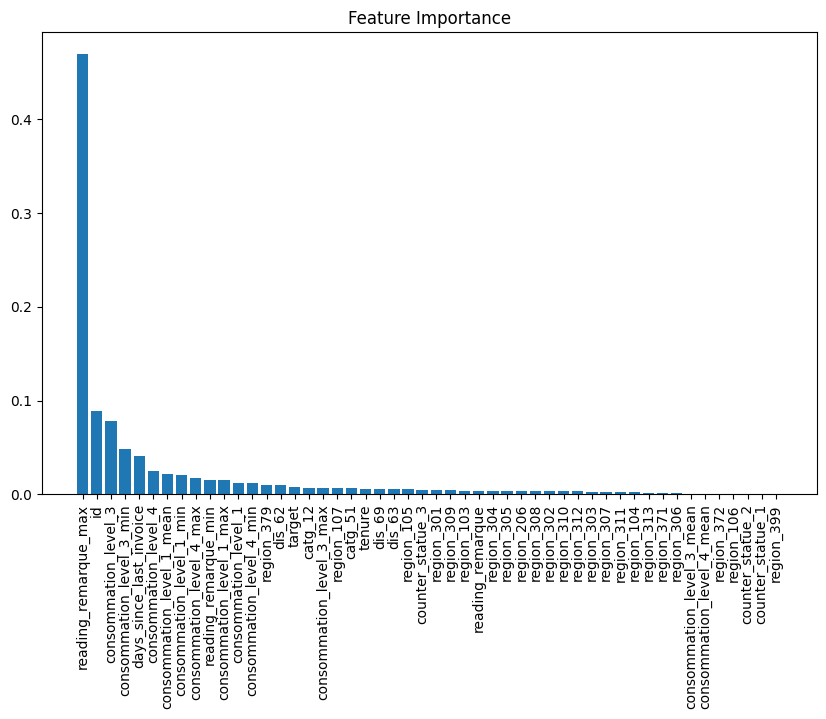

In [229]:
feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(data_merged_encoded.columns)[sorted_indices], rotation=90)
plt.show()

Performing tree pruning and looking at new Random Forest Model.

In [236]:
# Get feature importances and sort by importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Filter out less important features
important_features = indices[:10]  # Keep top 10 features, for example
xtrain_important = xtrain_resampled.iloc[:, important_features]
xtest_important = xtest.iloc[:, important_features]

# Retrain the model using only important features
rf_pruned = RandomForestClassifier(**best_params, random_state=0)
rf_pruned.fit(xtrain_important, ytrain_resampled)

# Make predictions
y_pred_rf_pruned = rf_pruned.predict(xtest_important)

print("Accuracy:", accuracy_score(ytest, y_pred_rf_pruned))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_rf_pruned))
print("Classification Report:\n", classification_report(ytest, y_pred_rf_pruned))


Accuracy: 0.8826155803026763
Confusion Matrix:
 [[32632  3161]
 [ 1361  1369]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94     35793
           1       0.30      0.50      0.38      2730

    accuracy                           0.88     38523
   macro avg       0.63      0.71      0.66     38523
weighted avg       0.91      0.88      0.90     38523



It can be seen that the recall rate of fraud cases is actually about 0.50 now which is a 50% chance of getting the fraud data correct. Which means that it is still not a great model for fraud detection.

In [238]:
# Fit the model to the training data
logit_reg.fit(xtrain_important, ytrain_resampled)

y_pred_lr_impt = logit_reg.predict(xtest_important)

# Print evaluation metrics
print("Accuracy:", accuracy_score(ytest, y_pred_lr_impt))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_lr_impt))
print("Classification Report:\n", classification_report(ytest, y_pred_lr_impt))

Accuracy: 0.6281961425641824
Confusion Matrix:
 [[22669 13124]
 [ 1199  1531]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.63      0.76     35793
           1       0.10      0.56      0.18      2730

    accuracy                           0.63     38523
   macro avg       0.53      0.60      0.47     38523
weighted avg       0.89      0.63      0.72     38523



/Users/angxavier/Documents/GitHub/IT1244-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


However, in the end, we still cannot get to the results we get from using our KNN model. Thus, we will be using KNN to classify fraud detection cases. 

Now we will cross validate our KNN model. 

In [25]:
# Perform cross-validation
cv_scores = cross_val_score(opt_knn, xtrain_resampled, ytrain_resampled, cv=5)  # cv=5 means 5-fold cross-validation

# Output the results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.96229121 0.96521947 0.96659396 0.96438282 0.96527819]
Mean cross-validation score: 0.964753131611395


It has a high cross validation score as well, thus proving to be a good model that we have built.

We will now save our KNN model using pickle.

In [255]:
# Save the model to a file
with open('data_files_and_model/model.bin', 'wb') as file:
    pickle.dump(opt_knn, file)